# MNIST Dataset

## Load and minibatch MNIST data

In [50]:
using Knet   
using Compat,GZip
using Images, Plots

In [2]:
"Where to download mnist from"
mnisturl = "http://yann.lecun.com/exdb/mnist"

"Where to download mnist to"
mnistdir = "MNIST/"


mnistdir

In [3]:
function gzload(file; path="$file", url="http://yann.lecun.com/exdb/mnist/$file")
    isfile(path) || download(url, path)
    f = gzopen(path)
    a = @compat read(f)
    close(f)
    return(a)
end

gzload (generic function with 1 method)

In [4]:
# That function is going to load raw data to the ram so that you will be able to use it
function loaddata()
    info("Loading MNIST...")
    # path = joinpath(mnistdir,file) etc.
    xtrn = gzload("MNIST/train-images-idx3-ubyte.gz")[17:end]
    xtst = gzload("MNIST/t10k-images-idx3-ubyte.gz")[17:end]
    ytrn = gzload("MNIST/train-labels-idx1-ubyte.gz")[9:end]
    ytst = gzload("MNIST/t10k-labels-idx1-ubyte.gz")[9:end]
    return (xtrn, ytrn, xtst, ytst)
end

loaddata (generic function with 1 method)

In [5]:
xtrnraw, ytrn, xtstraw, ytst = loaddata(); # These are raw data and not suitable to direct usage 

INFO: Loading MNIST...


In [6]:
mnistview(x,i)=colorview(Gray,permutedims(x[:,:,1,i],(2,1)))

mnistview (generic function with 1 method)

In [7]:
xtrn = convert(Array{Float32}, reshape(xtrnraw ./ 255, (28,28,1, div(length(xtrnraw), 784))));
xtst = convert(Array{Float32}, reshape(xtstraw ./ 255, (28,28,1, div(length(xtstraw), 784))));

In [8]:
# We have 10 class classification 0 is represented as 10th class
ytrn[ytrn.==0]=10;
ytst[ytst.==0]=10;

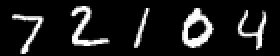

In [9]:
hcat([mnistview(xtst,i) for i=1:5]...)

In [10]:
ytrn[1:5]', ytst[1:5]'

(UInt8[0x05 0x0a … 0x01 0x09], UInt8[0x07 0x02 … 0x0a 0x04])

In [11]:
gpu()

0

In [12]:
Atype = gpu() >= 0 ? KnetArray{Float32} : Array{Float32}
dtst = minibatch(xtst,ytst,100;xtype=Atype) # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
dtrn = minibatch(xtrn,ytrn,100;xtype=Atype) # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
length(dtrn),length(dtst)

(600, 100)

In [13]:
# Here is the first minibatch
map(summary,first(dtst))  # (x,y) pair where x: 4-D Float32 array with X,Y,C,N  y: 1-D integer array

("28×28×1×100 Knet.KnetArray{Float32,4}", "100-element Array{UInt8,1}")

In [14]:
(x,y) = first(dtst);
y[1:5]'

1×5 RowVector{UInt8,Array{UInt8,1}}:
 0x07  0x02  0x01  0x0a  0x04

In [15]:
# Loss functions
zeroone(w,data,model) = 1 - accuracy(w,data,model)
softmax(w,data,model) = mean(softmax(w,x,y,model) for (x,y) in data)
softmax(w,x,y,model; o...) = nll(model(w,x;o...),y)
softgrad = grad(softmax)

(::gradfun) (generic function with 1 method)

### Train MNIST using MLP with Dropout for a start!

In [16]:
function mlpdrop(w,x; pdrop=(0,0))
    x = mat(x)
    x = dropout(x,pdrop[1])
    for i=1:2:length(w)-2
        x = relu.(w[i]*x .+ w[i+1])
        x = dropout(x,pdrop[2])
    end
    return w[end-1]*x .+ w[end]
end

mlpdrop (generic function with 1 method)

In [17]:
function winit(h...; std=0.01, x=784, y=10, atype=gpu()>=0 ? KnetArray{Float32} : Array{Float32})
    h = [x, h..., y]   # use winit(h1,h2,...,hn) for n hidden layer mlp
    w = Any[]
    for i=1:length(h)-1
        push!(w, std*randn(h[i+1],h[i]))
        push!(w, zeros(h[i+1],1))
    end
    map(atype, w)
end

winit (generic function with 1 method)

In [18]:
wts=winit(64) # gives weights and biases for an MLP with a single hidden layer of size 64

4-element Array{Knet.KnetArray{Float32,2},1}:
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007f2097800000, 200704, 0, nothing), (64, 784))
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007f2097600000, 256, 0, nothing), (64, 1))     
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007f2097400000, 2560, 0, nothing), (10, 64))   
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007f2097600200, 40, 0, nothing), (10, 1))      

In [19]:
softmax(wts,x,y,mlpdrop)  # Average loss for a single (x,y) minibatch

2.3024554f0

In [20]:
softmax(wts,dtst,mlpdrop)  # Average loss for the whole test set

2.3018637f0

In [26]:
# Train model(w) with SGD and return a list containing w for every epoch
function train(w,data,predict; epochs=50,lr=0.15,o...)
    weights = Any[deepcopy(w)]
    #opts = map(x->Sgd(lr=lr), w)#sgd with default learning rate
    opts = map(x->Adam(), w)
    for epoch in 1:epochs
        for (x,y) in data
            g = softgrad(w,x,y,predict;o...)
            update!(w,g,opts)  # w[i] = w[i] - lr * g[i]
        end
        push!(weights,deepcopy(w))
    end
    return weights
end

train (generic function with 1 method)

In [27]:
srand(1)
@time trn1=train(winit(48,16,x=784),dtrn,mlpdrop;epochs=50,lr=0.15,pdrop=(0.2,0))
@time trnloss1 = [ softmax(w,dtrn,mlpdrop) for w in trn1 ]
@time tstloss1 = [ softmax(w,dtst,mlpdrop) for w in trn1 ]
@time trnerr1 = [ zeroone(w,dtrn,mlpdrop) for w in trn1 ]
@time tsterr1 = [ zeroone(w,dtst,mlpdrop) for w in trn1 ]'


 18.323915 seconds (35.43 M allocations: 10.088 GiB, 4.00% gc time)
  5.327736 seconds (5.34 M allocations: 9.145 GiB, 8.31% gc time)
  0.910051 seconds (899.94 k allocations: 1.525 GiB, 8.41% gc time)
  5.128382 seconds (5.18 M allocations: 9.406 GiB, 8.60% gc time)
  0.895754 seconds (873.24 k allocations: 1.568 GiB, 8.67% gc time)


1×51 RowVector{Float64,Array{Float64,1}}:
 0.8968  0.137  0.1077  0.0898  0.0743  …  0.0404  0.0387  0.0392  0.0372

In [28]:
minimum(trnerr1),minimum(tsterr1)

(0.005499999999999949, 0.03620000000000001)

### Train MNIST using the Baseline CNN Model Mentioned in Section 5 of the Paper

In [56]:
function convnet(w,x; activation=(relu,relu), pdrop=(0,0,0))    # pdrop[1]:input, pdrop[2]:conv, pdrop[3]:fc
    for i=1:2:length(w)
        if ndims(w[i]) == 4     # convolutional layer
            x = dropout(x, pdrop[i==1?1:2])
            x = conv4(w[i], x, padding=1) .+ w[i+1]
            x = pool(activation[1].(x))
        elseif ndims(w[i]) == 2 # fully connected layer
            if i == length(w)-1; x = dropout(x, pdrop[i==1?1:3]); end
            # x = dropout(x, pdrop[i==1?1:3])  Hinton used dropout only in the final FC layer!
            x = w[i]*mat(x) .+ w[i+1]
            if i < length(w)-1; x = activation[2].(x); end
        else
            error("Unknown layer type: $(size(w[i]))")
        end
    end
    return x
end;

In [57]:
# Weight initialization for multiple layers
# h[i] is an integer for a fully connected layer, a triple of integers for convolution filters
# Output is an array [w0,b0,w1,b1,...,wn,bn] where wi,bi is the weight matrix/tensor and bias vector for the i'th layer
function cinit(h...)  # use cinit(x,h1,h2,...,hn,y) for n hidden layer model
    w = Any[]
    x = h[1]
    for i=2:length(h)
        if isa(h[i],Tuple)
            (x1,x2,cx) = x
            (w1,w2,cy) = h[i]
            push!(w, xavier(w1,w2,cx,cy))
            push!(w, zeros(1,1,cy,1))
            x = (div(x1-w1+1+2,2),div(x2-w2+1+2,2),cy) # assuming conv4 with p=0, s=1 and pool with p=0,w=s=2
        elseif isa(h[i],Integer)
            push!(w, xavier(h[i],prod(x)))
            push!(w, zeros(h[i],1))
            x = h[i]
        else
            error("Unknown layer type: $(h[i])")
        end
    end
    map(Atype, w)
end;

In [59]:
(x,y) = first(dtst)
softmax(cnnbase,x,y,convnet)

2.3034813f0

In [66]:
plotly()

Plots.PlotlyBackend()

In [82]:
weights = trnloss = tstloss = trnerr = tsterr = nothing; knetgc()

In [83]:
srand(1)
cnnbase=cinit((28,28,1), (5,5,256), (5,5,256), (5,5,128), 328, 192, 10)
@time weights=train(cnnbase,dtrn,convnet;epochs=25,lr=0.15,pdrop=(0,0,0.30))
@time trnloss = [ softmax(w,dtrn,convnet) for w in weights ]
@time tstloss = [ softmax(w,dtst,convnet) for w in weights ]
@time trnerr = [ zeroone(w,dtrn,convnet) for w in weights ]
@time tsterr = [ zeroone(w,dtst,convnet) for w in weights ]

622.107814 seconds (48.02 M allocations: 6.245 GiB, 22.21% gc time)
228.280464 seconds (9.27 M allocations: 4.938 GiB, 31.78% gc time)
 34.191367 seconds (1.55 M allocations: 843.287 MiB, 32.73% gc time)
219.682575 seconds (9.19 M allocations: 5.071 GiB, 31.87% gc time)
 40.914593 seconds (1.54 M allocations: 866.026 MiB, 30.44% gc time)


26-element Array{Float64,1}:
 0.8965
 0.0139
 0.0093
 0.0088
 0.0093
 0.0135
 0.0071
 0.0064
 0.0073
 0.0071
 0.0075
 0.0104
 0.0065
 0.0101
 0.008 
 0.0083
 0.0089
 0.0088
 0.0091
 0.0089
 0.0082
 0.0084
 0.0066
 0.0083
 0.007 
 0.0064

In [84]:
minimum(tstloss),minimum(tsterr)

(0.026876519f0, 0.006399999999999961)

In [85]:
plot([trnerr tsterr],ylim=(0,0.05),
    labels=[:trainErr :testErr],xlabel="Epochs", ylabel="Error with 20% dropout")  

In [86]:
trnerr

26-element Array{Float64,1}:
 0.8938     
 0.01445    
 0.00735    
 0.00588333 
 0.00561667 
 0.00861667 
 0.00263333 
 0.00306667 
 0.00173333 
 0.00165    
 0.00276667 
 0.00335    
 0.00215    
 0.00401667 
 0.00111667 
 0.00165    
 0.00185    
 0.00103333 
 0.00153333 
 0.00153333 
 0.000583333
 0.0009     
 0.0004     
 0.00085    
 0.000466667
 0.00015    

# AffNIST Dataset

In [25]:
"Where to download affNIST from"
affnisturl = "http://www.cs.toronto.edu/~tijmen/affNIST/32x/transformed/"

"Where to download affNIST to"
affnistdir = "affNIST/transformed/"

affnistdir

In [26]:
using MAT

In [27]:
# There are 32 training, 32 test and 32 validation files. Each training file contains 50K images, and
# Each test file contains 10K images, Only the first train and test files are read for now!
trndata = matread("affNIST/transformed/training_batches/1.mat")
tstdata = matread("affNIST/transformed/test_batches/1.mat")

Dict{String,Any} with 1 entry:
  "affNISTdata" => Dict{String,Any}(Pair{String,Any}("affNIST_id", [1 2 … 9999 …

In [28]:
trndata["affNISTdata"]

Dict{String,Any} with 8 entries:
  "affNIST_id"               => [1 2 … 49999 50000]
  "human_readable_transform" => [11.0947 1.00285 … 5.41724 15.2066; -0.0137585 …
  "image"                    => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0…
  "label_int"                => [0 1 … 6 5]
  "matrix_old_to_new"        => [1.07717 0.815535 … 0.92776 0.9824; -0.226662 -…
  "matrix_new_to_old"        => [0.891566 1.22425 … 1.07698 0.922488; 0.209849 …
  "original_id"              => [1 2 … 49999 50000]
  "label_one_of_n"           => Float32[1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; ……

In [29]:
xtrnraw = trndata["affNISTdata"]["image"];
xtstraw = tstdata["affNISTdata"]["image"];

In [30]:
ytrn, ytst = trndata["affNISTdata"]["label_int"], tstdata["affNISTdata"]["label_int"]

([0 1 … 6 5], [0 1 … 2 1])

In [31]:
ytrn[ytrn.==0]=10;
ytst[ytst.==0]=10;

In [32]:
map(summary,(xtrnraw,xtstraw))  # 50K + 10K 40x40 images stored in columns of size 1600

("1600×50000 Array{UInt8,2}", "1600×10000 Array{UInt8,2}")

In [33]:
xtrn = convert(Array{Float32}, reshape(xtrnraw ./ 255, (40,40,1, div(length(xtrnraw), 1600))));
xtst = convert(Array{Float32}, reshape(xtstraw ./ 255, (40,40,1, div(length(xtstraw), 1600))));

In [34]:
map(summary,(xtrn,xtst))

("40×40×1×50000 Array{Float32,4}", "40×40×1×10000 Array{Float32,4}")

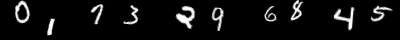

In [41]:
hcat([mnistview(xtrn,i) for i=1:10]...)

In [42]:
ytrn[1:10]'

1×10 RowVector{Int64,Array{Int64,1}}:
 10  1  7  3  2  9  6  8  4  5

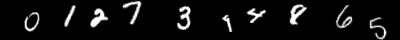

In [43]:
hcat([mnistview(xtst,i) for i=1:10]...)

In [44]:
ytst[1:10]'

1×10 RowVector{Int64,Array{Int64,1}}:
 10  1  2  7  3  9  4  8  6  5

In [45]:
dtst = minibatch(xtst,ytst,100;xtype=Atype) # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
dtrn = minibatch(xtrn,ytrn,100;xtype=Atype) # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
length(dtrn),length(dtst)

(500, 100)

In [46]:
# Here is the first minibatch
map(summary,first(dtst))  # (x,y) pair where x: 4-D Float32 array with X,Y,C,N  y: 1-D integer array

("40×40×1×100 Knet.KnetArray{Float32,4}", "1×100 Array{Int64,2}")

In [47]:
(x,y) = first(dtst)

(Knet.KnetArray{Float32,4}(Knet.KnetPtr(Ptr{Void} @0x00007faad009c400, 640000, 0, nothing), (40, 40, 1, 100)), [10 1 … 8 6])

In [48]:
w2=winit(64,x=1600) # gives weights and biases for an MLP with a single hidden layer of size 64

4-element Array{Knet.KnetArray{Float32,2},1}:
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007faad0138800, 409600, 0, nothing), (64, 1600))
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007faacae74400, 256, 0, nothing), (64, 1))      
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007faacada6200, 2560, 0, nothing), (10, 64))    
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007faacae13c00, 40, 0, nothing), (10, 1))       

In [49]:
softmax(w2,x,y,mlpdrop)  # Average loss for a single (x,y) minibatch

2.303099f0

In [50]:
softmax(w2,dtst,mlpdrop)  # Average loss for the whole test set

2.302607f0

In [51]:
srand(1)
@time trn2=train(winit(48,16,x=1600),dtrn,mlpdrop;epochs=50,lr=0.15,pdrop=(0.2,0))
@time trnloss2 = [ softmax(w,dtrn,mlpdrop) for w in trn2 ]
@time tstloss2 = [ softmax(w,dtst,mlpdrop) for w in trn2 ]
@time trnerr2 = [ zeroone(w,dtrn,mlpdrop) for w in trn2 ]
@time tsterr2 = [ zeroone(w,dtst,mlpdrop) for w in trn2 ]'

 12.573039 seconds (20.51 M allocations: 15.798 GiB, 7.36% gc time)
  7.161196 seconds (4.40 M allocations: 15.388 GiB, 10.11% gc time)
  1.466424 seconds (889.79 k allocations: 3.078 GiB, 10.15% gc time)
  7.129916 seconds (4.28 M allocations: 15.606 GiB, 10.39% gc time)
  1.450018 seconds (862.25 k allocations: 3.122 GiB, 10.40% gc time)


1×51 RowVector{Float64,Array{Float64,1}}:
 0.8994  0.8865  0.8051  0.7752  0.7285  …  0.3151  0.3136  0.3108  0.3175

In [52]:
minimum(trnerr2),minimum(tsterr2)

(0.18123999999999996, 0.30510000000000004)

# CIFAR Dataset

In [53]:
"Where to download cifar from"
cifarurl = "http://www.cs.toronto.edu/~kriz"

"Where to download cifar to"
cifardir = "CIFAR"

cifardir

In [54]:
# cifar10() => (xtrn,ytrn,xtst,ytst,labels)
function cifar10(; tgz="cifar-10-binary.tar.gz", dir="cifar-10-batches-bin",
                 trn=["data_batch_$i.bin" for i=1:5], tst=["test_batch.bin"],
                 lbl="batches.meta.txt", )
    global _cifar10_xtrn, _cifar10_ytrn, _cifar10_xtst, _cifar10_ytst, _cifar10_lbls
    if !isdefined(:_cifar10_xtrn)
        _cifar10_xtrn, _cifar10_ytrn, _cifar10_xtst, _cifar10_ytst, _cifar10_lbls = _cifar_read_tgz(tgz,dir,trn,tst,lbl)
    end
    return _cifar10_xtrn, _cifar10_ytrn, _cifar10_xtst, _cifar10_ytst, _cifar10_lbls
end

cifar10 (generic function with 1 method)

In [55]:
function _cifar_read_tgz(tgz,dir,trn,tst,labels)
    info("Reading $tgz...")
    if !isdir(cifardir)
        mkpath(cifardir)
    end
    dirpath = joinpath(cifardir,dir)
    if !isdir(dirpath)
        tgzpath = joinpath(cifardir,tgz)
        if !isfile(tgzpath)
            url = "$cifarurl/$tgz"
            download(url, tgzpath)
        end
        run(`tar xzf $tgzpath -C $cifardir`)
    end
    xtrn,ytrn = _cifar_read_files(dirpath,trn)
    xtst,ytst = _cifar_read_files(dirpath,tst)
    lbls = readlines(joinpath(dirpath,labels))
    return xtrn,ytrn,xtst,ytst,lbls
end

function _cifar_read_files(dir,files)
    xs,ys = [],[]
    for file in files
        x,y = _cifar_read_file(dir,file)
        push!(xs,x); push!(ys,y)
    end
    return cat(4, xs...), vcat(ys...)
end

function _cifar_read_file(dir,file)
    a = read(joinpath(dir,file))
    a = reshape(a, (3073, div(length(a),3073)))
    y = a[1,:] + 0x1 # first row is Int8 index representation of correct answers
    x = a[2:end,:] # rows 2:end give 32,32,3,N images
    # y = full(sparse(y,1:length(y),1f0,10,length(y))) # one-hot vector representation
    # maybe convert y to int?
    x = reshape(x ./ 255f0, (32,32,3,div(length(x),3072)))
    return (x,y)
end

_cifar_read_file (generic function with 1 method)

In [56]:
# The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
# There are 50000 training images and 10000 test images.
xtrn, ytrn, xtst, ytst, = cifar10();

INFO: Reading cifar-10-binary.tar.gz...


In [57]:
cifarview(x,i)=colorview(RGB,permutedims(x[:,:,:,i],(3,2,1)))

cifarview (generic function with 1 method)

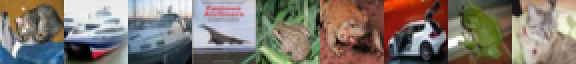

In [58]:
hcat([cifarview(xtst,i) for i=1:9]...)

In [59]:
# CLASSES are 1:airplane, 2:automobile, 3:bird, 4:cat, 5:deer, 6:dog, 7:frog, 8:horse, 9:ship, 10:truck
ytst[1:9]'

1×9 RowVector{UInt8,Array{UInt8,1}}:
 0x04  0x09  0x09  0x01  0x07  0x07  0x02  0x07  0x04

In [60]:
dtst = minibatch(xtst,ytst,100;xtype=Atype) # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
dtrn = minibatch(xtrn,ytrn,100;xtype=Atype) # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
length(dtrn),length(dtst)

(500, 100)

In [61]:
# Here is the first minibatch
map(summary,first(dtst))  # (x,y) pair where x: 4-D Float32 array with X,Y,C,N  y: 1-D integer array

("32×32×3×100 Knet.KnetArray{Float32,4}", "100-element Array{UInt8,1}")

In [62]:
(x,y) = first(dtst)

(Knet.KnetArray{Float32,4}(Knet.KnetPtr(Ptr{Void} @0x00007faaa4800000, 1228800, 0, nothing), (32, 32, 3, 100)), UInt8[0x04, 0x09, 0x09, 0x01, 0x07, 0x07, 0x02, 0x07, 0x04, 0x02  …  0x01, 0x04, 0x09, 0x07, 0x05, 0x07, 0x07, 0x01, 0x01, 0x08])

In [63]:
map(summary,(x,y))

("32×32×3×100 Knet.KnetArray{Float32,4}", "100-element Array{UInt8,1}")

In [64]:
w2=winit(64, x=32*32*3) # gives weights and biases for an MLP with a single hidden layer of size 64

4-element Array{Knet.KnetArray{Float32,2},1}:
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007faaa492c000, 786432, 0, nothing), (64, 3072))
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007faacae80600, 256, 0, nothing), (64, 1))      
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007faacadb5000, 2560, 0, nothing), (10, 64))    
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00007faacae53c00, 40, 0, nothing), (10, 1))       

In [65]:
softmax(w2,x,y,mlpdrop)  # Average loss for a single (x,y) minibatch

2.3048408f0

In [66]:
softmax(w2,dtst,mlpdrop)  # Average loss for the whole test set

2.3027565f0

In [67]:
srand(1)
@time trn3=train(winit(48,16,x=32*32*3),dtrn,mlpdrop;epochs=50,lr=0.15,pdrop=(0.2,0))
@time trnloss3 = [ softmax(w,dtrn,mlpdrop) for w in trn3 ]
@time tstloss3 = [ softmax(w,dtst,mlpdrop) for w in trn3 ]
@time trnerr3 = [ zeroone(w,dtrn,mlpdrop) for w in trn3 ]
@time tsterr3 = [ zeroone(w,dtst,mlpdrop) for w in trn3 ]'

 16.679536 seconds (20.55 M allocations: 29.493 GiB, 9.09% gc time)
 12.233638 seconds (4.45 M allocations: 29.356 GiB, 11.06% gc time)
  2.533214 seconds (899.50 k allocations: 5.872 GiB, 11.22% gc time)
 12.074564 seconds (4.32 M allocations: 29.573 GiB, 11.31% gc time)
  2.449884 seconds (872.98 k allocations: 5.915 GiB, 11.45% gc time)


1×51 RowVector{Float64,Array{Float64,1}}:
 0.8965  0.8054  0.7083  0.639  0.6182  …  0.5441  0.5347  0.5371  0.5437

In [68]:
minimum(trnerr3),minimum(tsterr3)

(0.48412, 0.5284)